#### Core Premise
We currently have a model that uses 8 months of training data to generate predictions. We would like to experiment to see if a version of the model which trains on 4 months of training data to predict conversion in the following 2 month period could be viable, so that the lead time to use is reduced.

In production, this could be used in such a way that the list of users predicted to convert within those two months can be placed on a priority list for a limited discount-promotions budget* Meanwhile, the data for the next round of predictions is being collected. 

For the purpose of the experiment, the available data will be divided into 6-month blocks, with the first 4 months of each block constituting the data collection period and the last two months constitutiing the performance period in which the target is whether or not a conversion took place. Subsets of these collection period + performance period pairs will be used for the training set, validation set, and test set respectively.

**Exploratory data analysis of relationship between adwords promotions & conversion was low, so a different type of nudge is suggested here*

### Preprocessing with Cutoff Date

In [1]:
import pandas as pd
import gc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [3]:
gstore = pd.read_csv("/Users/aoluwolerotimi/Datasets/train_dejsonified.csv")

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/3136096564.py:1: DtypeWarning: Columns (2,54) have mixed types. Specify dtype option on import or set low_memory=False.
  gstore = pd.read_csv("/Users/aoluwolerotimi/Datasets/train_dejsonified.csv")


In [4]:
gstore['date'] = pd.to_datetime(gstore['date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

In [5]:

print("Earliest Date:", (gstore['date']).min())
print("Latest Date:", (gstore['date']).max())

Earliest Date: 2016-08-01
Latest Date: 2017-08-01


6-month split is end of Feb 2017. First set will be beginning of August to end of Feb, second set will be beginning of March to beginning of August

In [6]:
cutoff_date = pd.to_datetime('2017-02-28')

In [7]:

gstore['date'] = pd.to_datetime(gstore['date'])
print(gstore['date'].dtype)

datetime64[ns]


In [8]:
df1 = gstore.loc[gstore['date'] <= cutoff_date]
# df2 = gstore.loc[gstore['date'] > cutoff_date]

In [10]:
# data collection cutoff dates (4 months in)
df1cutoff = pd.to_datetime('2016-11-30') 
df2cutoff = pd.to_datetime('2017-06-30')

In [17]:
# set aside collection period and performance period data
# df1p = df1.loc[df1['date'] > df1cutoff]  # performance
df1p = df1.loc[df1['date'] > df1cutoff, ['date', 'fullVisitorId', 'transactionRevenue']]  # performance
df1c = df1.loc[df1['date'] <= df1cutoff] # collection

In [13]:
df1trainids = df1c['fullVisitorId'].unique().tolist() # getting list of IDs for which we will check conversion in performance period

In [14]:
df1train = pd.DataFrame(df1trainids, columns=['fullVisitorId']) # beginnning construction of training dataframe

In [15]:
# identified as variables which would not aid analysis in earlier stages of the project
to_drop = ['socialEngagementType', 'networkDomain', 'latitude', 'longitude', 'networkLocation',
       'browser', 'browserVersion', 'browserSize', 'operatingSystem',
       'operatingSystemVersion', 'isMobile', 'mobileDeviceBranding',
       'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo',
       'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors',
       'screenResolution', 'bounces', 'keyword', 'referralPath','campaignCode', 'campaign']

In [18]:
for col in to_drop:
    if col in df1c.columns:
        df1c.drop(col, axis=1, inplace = True)

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/1340032264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1c.drop(col, axis=1, inplace = True)
/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/1340032264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1c.drop(col, axis=1, inplace = True)
/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/1340032264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [19]:
# create label for conversion in performance period

# Step 1: Create a Boolean Series where True represents a non-null transactionRevenue
converted_visitors = df1p['transactionRevenue'].notnull()

# Step 2: Group by 'fullVisitorId' in df1p and check if any transactionRevenue entries are not null
conversion_status = df1p[converted_visitors].groupby('fullVisitorId').size() > 0

# Step 3: Map the conversion status back to df1c to create the 'targetConversion' column
df1train['targetConversion'] = df1train['fullVisitorId'].map(conversion_status).fillna(0).astype(int)


In [81]:
# turning it into a function to reuse
def conv_label(performance_df, groupby_col, result_df):
    """
    Creates a 'targetConversion' column in the result DataFrame based on conversion data from the performance DataFrame.
    
    Parameters:
        performance_df (pd.DataFrame): DataFrame containing performance data, including 'transactionRevenue'.
        groupby_col (str): Column name to group by, typically 'fullVisitorId'.
        result_df (pd.DataFrame): DataFrame to which the 'targetConversion' results will be added.
        
    Returns:
        pd.DataFrame: The modified result DataFrame with a new 'targetConversion' column.
    """
    # Step 1: Create a Boolean Series where True represents a non-null transactionRevenue
    converted_visitors = performance_df['transactionRevenue'].notnull()

    # Step 2: Group by the specified column in performance_df and check if any transactionRevenue entries are not null
    conversion_status = performance_df[converted_visitors].groupby(groupby_col).size() > 0

    # Step 3: Map the conversion status back to the result DataFrame to create the 'targetConversion' column
    result_df['targetConversion'] = result_df[groupby_col].map(conversion_status).fillna(0).astype(int)

    return result_df

In [20]:
sum(df1train['targetConversion'])

409

In [21]:
# creating column for if user visited for first time in collection period
firstime_visitors = df1c['newVisits'].notnull()
firstime_status = df1c[firstime_visitors].groupby('fullVisitorId').size() > 0
df1train['newVisits'] = df1train['fullVisitorId'].map(firstime_status).fillna(0).astype(int)

In [38]:
columns_to_encode = ['channelGrouping', 'deviceCategory', 'source']
df1c = pd.get_dummies(df1c, columns=columns_to_encode)

In [30]:
df1c.columns

Index(['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber',
       'visitStartTime', 'continent', 'subContinent', 'country', 'region',
       ...
       'source_wanelo.com', 'source_wap.sogou.com', 'source_web.facebook.com',
       'source_web.mail.comcast.net', 'source_web.telegram.org',
       'source_wheretoget.it', 'source_xbidprodmirror.corp.google.com',
       'source_yahoo', 'source_yandex', 'source_youtube.com'],
      dtype='object', length=263)

In [39]:
agg_dict = {
    'country': 'first',
    'continent': 'first',
    'subContinent': 'first',
    'transactionRevenue': 'sum',
    'pageviews': 'sum',
    'isTrueDirect': 'sum'

}

In [40]:
dummy_columns = [col for col in df1c.columns if '_' in col]

In [41]:
for dummy_col in dummy_columns:
    agg_dict[dummy_col] = 'sum'

In [42]:
# making sure columns match
incorrect_cols = [key for key in agg_dict if key not in df1c.columns]
print(incorrect_cols)


[]


In [43]:
df1c['isTrueDirect'] = df1c['isTrueDirect'].fillna(False).astype(int)

In [44]:
df1c['isTrueDirect'].value_counts()

0    270015
1     87254
Name: isTrueDirect, dtype: int64

In [46]:
useragg = df1c.groupby('fullVisitorId').agg(agg_dict)

In [47]:
useragg.reset_index(inplace=True)

In [22]:
aggregations = {
    # Count how many times each visitor appears
    'fullVisitorId': 'count',
    # Count non-null records for transactionRevenue
    'transactionRevenue': lambda x: x.notnull().sum(),
    # Count rows where adwordsClickInfo.gclId is populated
    'adwordsClickInfo.gclId': lambda x: x.notnull().sum()
}

In [24]:
visitor_counts = df1c.groupby('fullVisitorId').agg(aggregations)

In [25]:
visitor_counts.columns = ['visits', 'conversions', 'adVisits']

In [27]:
visitor_counts.reset_index(inplace=True)

In [28]:
visitor_counts.head()

,fullVisitorId,visits,conversions,adVisits
0,4823595352351,1,0,0
1,5103959234087,1,0,0
2,10278554503158,1,0,0
3,20424342248747,1,0,0
4,33471059618621,1,0,0


In [30]:
df1train = df1train.merge(visitor_counts, on='fullVisitorId', how='left')

In [48]:
df1train = df1train.merge(useragg, on='fullVisitorId', how='left')

In [54]:
df1train['pageviews'] = df1train['pageviews'].astype(int)

In [56]:
# reversing the transformation of transactionRevenue in google analytics
df1train['transactionRevenue'] = (df1train['transactionRevenue'] / 1000000).round(2)

In [58]:
df1train.head().style

,fullVisitorId,targetConversion,newVisits,visits,conversions,adVisits,country,continent,subContinent,transactionRevenue,pageviews,isTrueDirect,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,source_(direct),source_(not set),source_0.shared.bow.cat2.ads-bow.lf.borg.google.com:9817,source_0.shared.bow.cat2.ads-bow.lf.borg.google.com:9824,source_0.shared.bow.cat2.ads-bow.lf.borg.google.com:9857,source_0.shared.bow.cat2.ads-bow.lf.borg.google.com:9860,source_0.shared.bow.cat2.ads-bow.lf.borg.google.com:9879,source_0.shared.bow.cat2.ads-bow.lf.borg.google.com:9898,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9801,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9819,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9830,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9831,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9834,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9846,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9848,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9873,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9885,source_0.shared.bow.cat2.ads-bow.qk.borg.google.com:9899,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9813,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9835,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9839,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9849,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9850,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9859,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9861,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9876,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9885,source_9to5google.com,source_Partners,source_ad.doubleclick.net,source_adwords-displayads-nightly.corp.google.com,source_adwords-displayads.googleusercontent.com,source_adwords-prod-west.qa.adz.google.com,source_adwords.google.com,source_amazon.com,source_analytics.google.com,source_aol,source_arstechnica.com,source_ask,source_au.search.yahoo.com,source_ausdroid.net,source_awics.corp.google.com,source_baidu,source_baidu.com,source_basecamp.com,source_bing,source_blackboard.neu.edu,source_blog.golang.org,source_blognone.com,source_business.facebook.com,source_businessinsider.com,source_calendar.google.com,source_cases.corp.google.com,source_chatwork.com,source_cl-cards.googleplex.com,source_col128.mail.live.com,source_connect.googleforwork.com,source_course.fso.fullsail.edu,source_crowdcompute.googleplex.com,source_cse.google.com,source_csfirst.withgoogle.com,source_dealspotr.com,source_dfa,source_docs.google.com,source_drawnames.com,source_duckduckgo.com,source_evernote.com,source_facebook.com,source_feedly.com,source_g3doc.corp.google.com,source_gatewaycdi.com,source_getiriver.com,source_getpocket.com,source_github.com,source_go.mail.ru,source_google,source_google.be,source_google.ca,source_google.ch,source_google.co.id,source_google.co.il,source_google.co.in,source_google.co.jp,source_google.co.kr,source_google.co.nz,source_google.co.th,source_google.co.uk,source_google.co.za,source_google.com,source_google.com.ar,source_google.com.au,source_google.com.br,source_google.com.co,source_google.com.hk,source_google.com.mx,source_google.com.ng,source_google.com.ph,source_google.com.pk,source_google.com.sa,source_google.com.sg,source_google.com.tw,source_google.com.ua,source_google.cz,source_google.de,source_google.es,source_google.fr,source_google.gatewaycdi.com,source_google.gr,source_google.it,source_google.nl,source_google.pl,source_google.ro,source_google.rs,source_google.ru,source_google.se,source_google.sk,source_googleads.g.doubleclick.net,source_googleux.perksplus.com,source_googleweblight.com,source_gophergala.com,source_goto.google.com,source_groups.google.com,source_grow.googleplex.c

In [59]:
# save to csv before this kernel crashes
df1train.to_csv('df1train2.csv', index=True)

**Setting up similar df for df2 (likely this will be the validation and test set)**

In [60]:
df2 = gstore.loc[gstore['date'] > cutoff_date]

In [61]:
df2p = df2.loc[df2['date'] > df2cutoff, ['date', 'fullVisitorId', 'transactionRevenue']]  # performance
df2c = df2.loc[df2['date'] <= df2cutoff] # collection

In [62]:
for col in to_drop:
    if col in df2c.columns:
        df2c.drop(col, axis=1, inplace = True)

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/191186508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2c.drop(col, axis=1, inplace = True)
/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/191186508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2c.drop(col, axis=1, inplace = True)
/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/191186508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [64]:
df2c['isTrueDirect'] = df2c['isTrueDirect'].fillna(False).astype(int)

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/2153057882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2c['isTrueDirect'] = df2c['isTrueDirect'].fillna(False).astype(int)


In [74]:
df2c['pageviews'].fillna(0, inplace= True)

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/3819725415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2c['pageviews'].fillna(0, inplace= True)


In [76]:
df2c['pageviews'] = df2c['pageviews'].astype(int)

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_68147/712655511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2c['pageviews'] = df2c['pageviews'].astype(int)


In [79]:
df2testids = df2c['fullVisitorId'].unique().tolist() 

In [80]:
df2test = pd.DataFrame(df2testids, columns=['fullVisitorId'])

In [82]:
df2test = conv_label(df2p, 'fullVisitorId', df2test)

In [84]:
df2test['targetConversion'].sum() # remember to do stratified sample on val & test split

239

In [85]:
firstime_visitors = df2c['newVisits'].notnull()
firstime_status = df2c[firstime_visitors].groupby('fullVisitorId').size() > 0
df2test['newVisits'] = df2test['fullVisitorId'].map(firstime_status).fillna(0).astype(int)

In [86]:
df2test.head()

,fullVisitorId,targetConversion,newVisits
0,6136444193474843946,0,1
1,9499266297099251015,0,1
2,965275377736384905,0,1
3,4609130972135924274,0,1
4,7154533339220730030,0,1


In [87]:
df2c = pd.get_dummies(df2c, columns=columns_to_encode)

In [88]:
agg2_dict = {
    'country': 'first',
    'continent': 'first',
    'subContinent': 'first',
    'transactionRevenue': 'sum',
    'pageviews': 'sum',
    'isTrueDirect': 'sum'

}

In [89]:
dummy_columns = [col for col in df2c.columns if '_' in col]
for dummy_col in dummy_columns:
    agg2_dict[dummy_col] = 'sum'

In [90]:
incorrect_cols = [key for key in agg2_dict if key not in df2c.columns]
print(incorrect_cols)

[]


In [91]:
useragg2 = df2c.groupby('fullVisitorId').agg(agg2_dict)

In [96]:
useragg2.reset_index(inplace=True)

In [93]:
# del visitor_counts

In [94]:
visitor_counts = df2c.groupby('fullVisitorId').agg(aggregations)
visitor_counts.columns = ['visits', 'conversions', 'adVisits']
visitor_counts.reset_index(inplace=True)

In [95]:
df2test = df2test.merge(visitor_counts, on='fullVisitorId', how='left')

In [97]:
df2test= df2test.merge(useragg2, on='fullVisitorId', how='left')

In [100]:
df2test.head().style

,fullVisitorId,targetConversion,newVisits,visits,conversions,adVisits,country,continent,subContinent,transactionRevenue,pageviews,isTrueDirect,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,source_(direct),source_(not set),source_0.shared.bow.cat2.ads-bow.tg.borg.google.com:9864,source_0.shared.bow.cat2.ads-bow.tl.borg.google.com:9847,source_0.shared.bow.cat2.ads-bow.vk.borg.google.com:9878,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9801,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9815,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9816,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9820,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9835,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9856,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9862,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9875,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9880,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9895,source_0.shared.bow.cat2.ads-bow.yw.borg.google.com:9898,source_9to5google.com,source_Partners,source_admin.globalaccess.com,source_adwords-displayads.googleusercontent.com,source_adwords-next-devel.qa.adz.google.com,source_adwords-next-nightly.qa.adz.google.com,source_adwords.google.com,source_amazon.com,source_analytics.corp.google.com,source_analytics.google.com,source_aol,source_apis.mail.yahoo.com,source_ask,source_au.search.yahoo.com,source_ausdroid.net,source_away.vk.com,source_awics.corp.google.com,source_baidu,source_baidu.com,source_benkraft.mtv.corp.google.com:9000,source_bing,source_bing.com,source_blog.golang.org,source_blognone.com,source_br.pinterest.com,source_br.search.yahoo.com,source_businessinsider.com,source_businessinsider.in,source_ca.search.yahoo.com,source_cases.corp.google.com,source_cc.csusm.edu,source_centrum.cz,source_chat.google.com,source_cl-cards.googleplex.com,source_cn.bing.com,source_computerworld.com,source_connect.googleforwork.com,source_course.fso.fullsail.edu,source_crowdcompute.googleplex.com,source_datastudio.google.com,source_dealspotr.com,source_dena-design.qiita.com,source_desktop.google.com.ua,source_dfa,source_docs.google.com,source_duckduckgo.com,source_dynamite.sandbox.google.com,source_en.wikipedia.org,source_es.search.yahoo.com,source_espanol.search.yahoo.com,source_evernote.com,source_ex.fit.edu,source_facebook.com,source_feedly.com,source_finance.yahoo.com,source_fletch.teams.x20web.corp.google.com,source_flipboard.com,source_fr.search.yahoo.com,source_gdeals-stg.googleplex.com,source_gdeals.googleplex.com,source_getiriver.com,source_getpocket.com,source_gist.github.com,source_github.com,source_go.mail.ru,source_good.barkpost.com,source_google,source_google.at,source_google.ca,source_google.ch,source_google.cl,source_google.co.id,source_google.co.in,source_google.co.jp,source_google.co.kr,source_google.co.nz,source_google.co.th,source_google.co.uk,source_google.co.za,source_google.com,source_google.com.au,source_google.com.br,source_google.com.hk,source_google.com.mx,source_google.com.pe,source_google.com.ph,source_google.com.pk,source_google.com.tw,source_google.com.ua,source_google.de,source_google.es,source_google.fr,source_google.it,source_google.lk,source_google.nl,source_google.no,source_google.pl,source_google.rs,source_google.ru,source_googleads.g.doubleclick.net,source_googleux.perksplus.com,source_googleweblight.com,source_gophergala.com,source_groups.google.com,source_grow.googleplex.com,source_growcms.googleplex.com,source_gsuite.google.com,source_gtm-dogfood.corp.google.com,source_gtm-preprod-dogfood.corp.google.com,source_hangouts.google.com,source_ics-devel-west.qa.adz.google.com,source_images.google,source_images.google.co.id,source_images.google.ie,source_in.search.yahoo.com,source_inbox.goog

In [101]:
df2test.to_csv('df2test.csv', index=True)

#### Remaining Encoding and Dimensionality Reduction

In [105]:
# original gstore df no longer needed. freeing up memory
del gstore

In [104]:
source_columns = [col for col in df1train.columns if col.startswith('source_')]
source_data = df1train[source_columns]

In [106]:
scaler = StandardScaler()
source_data_scaled = scaler.fit_transform(source_data)

In [107]:
pca = PCA(n_components=20)
principal_components = pca.fit_transform(source_data_scaled)
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(20)])

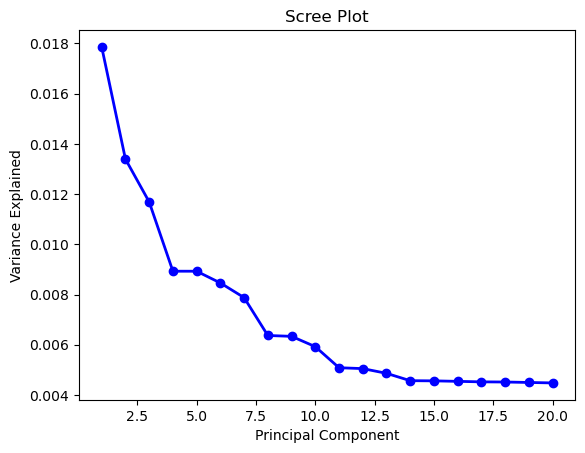

In [110]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Ideal number of components based on training set is 11

In [150]:
pca = PCA(n_components=11)
principal_components = pca.fit_transform(source_data_scaled)

# DataFrame for principal components
pc_df = pd.DataFrame(data=principal_components, 
                     columns=[f'PCSource{i+1}' for i in range(11)],
                     index=df1train.index)  # Using the same index to align with the original data


In [113]:
# Concatenating the PCA columns back
df1train = pd.concat([df1train, pc_df], axis=1)

In [114]:
# with this done, the original source columns can be dropped
for col in source_columns:
    if col in df1train.columns:
        df1train.drop(col, axis=1, inplace = True)

In [117]:
print("Number of unique values in country column:", df1train['country'].nunique())

Number of unique values in country column: 213


**Creating principal components for Country**

In [118]:
df1train = pd.get_dummies(df1train, columns=['country'])

In [119]:
country_columns = [col for col in df1train.columns if col.startswith('country_')]
country_data = df1train[country_columns]

In [120]:
country_data_scaled = scaler.fit_transform(country_data)

In [121]:
pca = PCA(n_components=20)
principal_components = pca.fit_transform(country_data_scaled)
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(20)])

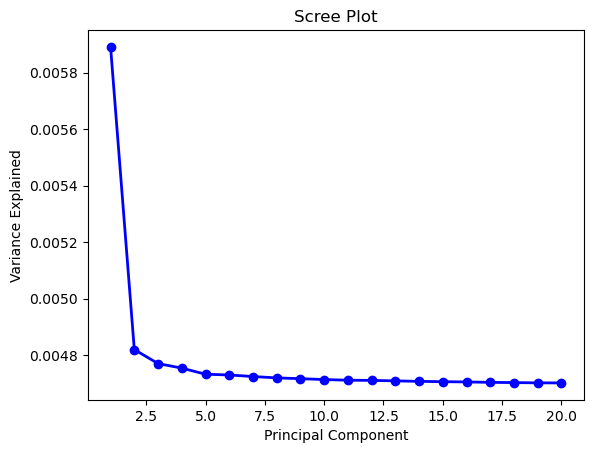

In [122]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [123]:
pca.explained_variance_ratio_

array([0.00589062, 0.00482043, 0.00477073, 0.00475478, 0.00473313,
       0.00473043, 0.00472499, 0.00472017, 0.00471738, 0.0047143 ,
       0.00471194, 0.00471128, 0.00470963, 0.00470788, 0.00470673,
       0.00470583, 0.00470431, 0.00470353, 0.00470262, 0.00470235])

In [125]:
# Very low explained variance from each. Checking further
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance for 20 components:", cumulative_variance)

Cumulative explained variance for 20 components: [0.00589062 0.01071105 0.01548178 0.02023656 0.0249697  0.02970012
 0.03442511 0.03914528 0.04386266 0.04857695 0.05328889 0.05800018
 0.06270981 0.06741769 0.07212443 0.07683026 0.08153457 0.0862381
 0.09094072 0.09564307]


Insufficient reduction in dimensionality. EDA had shown most users were in North America. Will instead create a binary flag for whether a user is from North America

In [127]:
df1train['North America'] = np.where(df1train['subContinent'] == 'Northern America', 1, 0)

In [129]:
# dropping unecessary columns
for col in country_columns:
    if col in df1train.columns:
        df1train.drop(col, axis=1, inplace = True)

In [148]:
df1train.columns

Index(['fullVisitorId', 'targetConversion', 'newVisits', 'visits',
       'conversions', 'adVisits', 'transactionRevenue', 'pageviews',
       'isTrueDirect', 'channelGrouping_(Other)', 'channelGrouping_Affiliates',
       'channelGrouping_Direct', 'channelGrouping_Display',
       'channelGrouping_Organic Search', 'channelGrouping_Paid Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'deviceCategory_desktop', 'deviceCategory_mobile',
       'deviceCategory_tablet', 'PCSource1', 'PCSource2', 'PCSource3',
       'PCSource4', 'PCSource5', 'PCSource6', 'PCSource7', 'PCSource8',
       'PCSource9', 'PCSource10', 'PCSource11', 'North America'],
      dtype='object')

In [16]:
to_drop.append('continent')

In [17]:
to_drop.append('subContinent')

In [ ]:
for col in to_drop:
    if col in df1train.columns:
        df1train.drop(col, axis=1, inplace = True)

In [149]:
# df1train.to_csv('df1train3.csv', index=True)

**Performing same operations on test data**

In [2]:
df2test = pd.read_csv("/Users/aoluwolerotimi/Documents/EDS II/df2test.csv", index_col=0) # restarting due to error along the way 

/var/folders/z1/1zds15w97_g7_fhs4_83dc3m0000gn/T/ipykernel_74022/1424963017.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2test = pd.read_csv("/Users/aoluwolerotimi/Documents/EDS II/df2test.csv", index_col=0) # restarting due to error along the way


In [3]:
df2test.shape

(212422, 253)

In [4]:
df2test['transactionRevenue'] = (df2test['transactionRevenue'] / 1000000).round(2)

In [5]:
source_columns_test = [col for col in df2test.columns if col.startswith('source_')]
source_data_test = df2test[source_columns_test]

In [6]:
scaler = StandardScaler()
source_data_scaled_test = scaler.fit_transform(source_data_test)

In [7]:
pca = PCA(n_components=11)
principal_components_test = pca.fit_transform(source_data_scaled_test)

In [8]:
pc_df_test = pd.DataFrame(data=principal_components_test, 
                     columns=[f'PCSource{i+1}' for i in range(11)],
                     index=df2test.index)

In [9]:
# Concatenating the PCA columns back
df2test = pd.concat([df2test, pc_df_test], axis=1)

In [10]:
# with this done, the original source columns can be dropped
for col in source_columns_test:
    if col in df2test.columns:
        df2test.drop(col, axis=1, inplace = True)

In [11]:
df2test['North America'] = np.where(df2test['subContinent'] == 'Northern America', 1, 0)

In [12]:
df2test.shape

(212422, 35)

In [13]:
df2test.columns

Index(['fullVisitorId', 'targetConversion', 'newVisits', 'visits',
       'conversions', 'adVisits', 'country', 'continent', 'subContinent',
       'transactionRevenue', 'pageviews', 'isTrueDirect',
       'channelGrouping_(Other)', 'channelGrouping_Affiliates',
       'channelGrouping_Direct', 'channelGrouping_Display',
       'channelGrouping_Organic Search', 'channelGrouping_Paid Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'deviceCategory_desktop', 'deviceCategory_mobile',
       'deviceCategory_tablet', 'PCSource1', 'PCSource2', 'PCSource3',
       'PCSource4', 'PCSource5', 'PCSource6', 'PCSource7', 'PCSource8',
       'PCSource9', 'PCSource10', 'PCSource11', 'North America'],
      dtype='object')

In [18]:
for col in to_drop:
    if col in df2test.columns:
        df2test.drop(col, axis=1, inplace = True)

In [19]:
df2test.drop('country', axis= 1,inplace= True)

In [20]:
df2test.shape

(212422, 32)

In [22]:
df1train.shape

(299074, 32)

In [21]:
df1train = pd.read_csv("/Users/aoluwolerotimi/Documents/EDS II/df1train3.csv", index_col= 0)

In [23]:
df2test.to_csv("df2test2.csv", index = True)

In [24]:
# Checking columns same in train and test / val
columns_equal = set(df1train.columns) == set(df2test.columns)
print("Columns in df1train and df2test are the same:", columns_equal)

Columns in df1train and df2test are the same: True


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Split the data into validation and test sets
val_set, test_set = train_test_split(
    df2test,                # Dataframe to split
    test_size=0.5,          # Fraction of data to be used as the second part
    random_state=42,        # Seed for the random number generator (for reproducibility)
    stratify=df2test['targetConversion']  # Column to use for stratification
)

In [27]:
# Print the sizes of the splits to verify the operation
print("Validation set size:", val_set.shape)
print("Test set size:", test_set.shape)

Validation set size: (106211, 32)
Test set size: (106211, 32)


In [28]:
val_set.to_csv("val_set", index = True)
test_set.to_csv("test_set", index = True)